# Otimização de hiperparâmetros e avaliação final

## Setup

In [259]:
!pip install pandas plotly matplotlib seaborn scikit-learn xgboost optuna hyperopt setuptools nbformat

/bin/bash: /home/leonardoazzi/cic/24-2/ml/trabalho/student-dropout-prediction/src/env/bin/pip: /home/leonardoazzi/cic/24-2/ml/student-dropout-prediction/env/bin/python3: interpretador incorreto: Arquivo ou diretório inexistente


In [260]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Biblioteca com algoritmos específicos de machine learning
from xgboost import XGBClassifier

# Módulo para balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import optuna
from optuna.visualization import plot_optimization_history, plot_slice, plot_contour, plot_parallel_coordinate, plot_param_importances
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

## Carregamento dos dados

Dataset pré-processado no notebook [t1-spot-checking.ipynb](./t1-spot-checking.ipynb)

---
Dataset obtido em https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [ ]:
data = pd.read_csv("../data/clean-dataset.csv")

# 1. Otimização de hiperparâmetros

Cada algoritmo escolhido como resultado do T1 deve ser treinado para obter o melhor desempenho possível. Não havendo um referencial de desempenho para o problema, os grupos devem reportar o melhor modelo dentre todos os que foram treinados e avaliados. Isso envolve o melhor ajuste de hiperparâmetros que for possível encontrar. Automatizar essa etapa de otimização de hiperparâmetros pode economizar bastante esforço. O scikit-learn oferece o GridSearch que é uma busca exaustiva trivial. Assim, bibliotecas que implementam algoritmos mais “inteligentes”, como Hyperopt e Optuna, podem ser um diferencial na obtenção de um bom desempenho.

Os grupos devem garantir que a metodologia de pré-processamento, treino e validação esteja correta. Um aspecto particularmente crítico é a prevenção de data leakage (ie, vazamento de dados), que pode comprometer os resultados e a validade do modelo. Por exemplo, o cálculo das estatísticas de pré-processamento (e.g. fit do scikit-learn para normalização, balanceamento de dados e imputação) só pode ser feito nos dados de treino. Esse cálculo é, então, aplicado (e.g. transform do scikit-learn) nos dados de treino, validação e teste. Além disso, a otimização de hiperparâmetros deve ser avaliada no conjunto de validação e não no de teste.

A divisão dos dados em treino, validação e teste pode ser feita via holdout de 3-vias ou holdout+validação cruzada (CV), onde o holdout separa o de teste e o restante é dividido conforme a validação cruzada, ou validação cruzada (CV) aninhada. Os grupos devem avaliar qual a melhor estratégia, balanceando a confiabilidade do método (e.g. validação cruzada aninhada garante mais variabilidade nos dados) vs o tempo de execução (e.g. 5-folds externos e 3-folds internos de CV aninhada fazem com que cada possível modelo seja treinado e avaliado 15 vezes). Independente do método escolhido, a divisão dos dados deve ser estratificada (e.g. mesmo percentual de cada classe no treino, validação e teste).

In [262]:
# Algoritmos selecionados para otimização de hiperparâmetros

lr = LogisticRegression()
abc = AdaBoostClassifier()
svmachine = svm.SVC(probability=True)

algo_dict = {'Logistic Regression': lr, 'AdaBoost': abc, 'SVM': svmachine}

In [263]:
# Referências
# https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
def make_pipeline(model):
    steps = list()

    steps.append(('Feature Selection', SelectKBest(k=4, score_func=mutual_info_classif)))
    steps.append(('Normalização', StandardScaler()))
    steps.append(('Balanceamento da classe minoritária', SMOTE(sampling_strategy='minority')))
    steps.append(('Modelo', model))

    # Cria a pipeline
    pipe = Pipeline(steps=steps)

    return pipe

## Grid e Random Search

In [264]:
# def define_grid_search_params(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__max_depth': [10, 20, 30]
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': [5, 10, 20, 30]
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10, 100]
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': [3, 5, 7, 10]
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__learning_rate': [0.01, 0.1, 1]
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10],
#             'Modelo__kernel': ['linear', 'rbf']
#         }
#     else:
#         raise ValueError(f"Não foi definido parâmetro para o modelo: {model_name}")

In [265]:
# def nested_cv_with_gridsearch(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():
#         param_grid = define_grid_search_params(model_name)

#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             pipeline = make_pipeline(model)

#             grid_search = GridSearchCV(
#                 estimator=pipeline,
#                 param_grid=param_grid,
#                 cv=StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42),
#                 scoring=metric,
#                 n_jobs=-1
#             )

#             grid_search.fit(X_train, y_train)

#             best_pipeline = grid_search.best_estimator_
#             y_pred = best_pipeline.predict(X_test)

#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [266]:
# results_df = nested_cv_with_gridsearch(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [267]:
# def define_hyperopt_space(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'n_neighbors': hp.quniform('n_neighbors', 3, 20, 1),
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(2)),
#         }
#     elif model_name == 'SVM':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#             'kernel': hp.choice('kernel', ['linear', 'rbf']),
#         }

In [268]:
# def nested_cv_with_hyperopt(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():

#         # Define objective function for Hyperopt
#         def objective(params):
#             # If SVM, map the kernel index to string for correct cross-validation
#             if 'kernel' in params and model_name == 'SVM':
#                 kernel_mapping = ['linear', 'rbf']
#                 if isinstance(params['kernel'], int):
#                     params['kernel'] = kernel_mapping[params['kernel']]

#             pipeline = make_pipeline(model)

#             # Convert integer-like floats to int
#             final_params = {}
#             for k, v in params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)  # Convert to int if it is a whole number float
#                 final_params[f'Modelo__{k}'] = v

#             pipeline.set_params(**final_params)

#             inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)
#             scores = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1)
#             return {'loss': -np.mean(scores), 'status': STATUS_OK}

#         # Outer loop
#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             search_space = define_hyperopt_space(model_name)
#             trials = Trials()

#             best_params = fmin(
#                 fn=objective,
#                 space=search_space,
#                 algo=tpe.suggest,
#                 max_evals=20,
#                 trials=trials,
#             )

#             # Map SVM kernel back if needed
#             if model_name == 'SVM' and 'kernel' in best_params:
#                 kernel_mapping = ['linear', 'rbf']
#                 best_params['kernel'] = kernel_mapping[best_params['kernel']]

#             # Convert parameters and retrain pipeline
#             final_params = {}
#             for k, v in best_params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)
#                 final_params[f'Modelo__{k}'] = v

#             # Train the pipeline with the best parameters
#             pipeline = make_pipeline(model)
#             pipeline.set_params(**final_params)
#             pipeline.fit(X_train, y_train)

#             # Evaluate on the test set
#             y_pred = pipeline.predict(X_test)
#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [269]:
# results_df = nested_cv_with_hyperopt(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [270]:
# def define_optuna_space(model_name, trial):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 300),
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': trial.suggest_int('n_neighbors', 3, 20)
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
#             'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
#             'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
#         }

## Optuna

### Config

In [271]:
def define_optuna_space(model_name, trial):
    
    # Define o espaço de busca de hiperparâmetros para cada tipo de modelo
    if model_name == 'Logistic Regression':

        # Caso a gente queira fazer uma avaliação mais simples:
        # # Para regressão logística, ajusta o parâmetro de regularização C
        # return {
        #     'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
        # }

        # Senão, com mais hiperparâmetros:
        solver_penalty_str = trial.suggest_categorical(
            'solver_penalty',
            ['liblinear_l1', 'liblinear_l2', 'lbfgs_l2']
        )

        # Quebra as strings de maneira a ter o solver e a penalidade certa
        solver, penalty = solver_penalty_str.split('_')

        return {
            'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
            'Modelo__solver': solver,
            'Modelo__penalty': penalty
        }

    elif model_name == 'AdaBoost':
        # Para AdaBoost, ajusta o número de estimadores e a taxa de aprendizado
        return {
            'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
        }
    elif model_name == 'SVM':
        # Para SVM, ajusta o parâmetro C e o tipo de kernel
        return {
            'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
            'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
        }
    else:
        # Se nenhum hiperparâmetro estiver definido no modelo, retorna um dicionário vazio
        return {}

In [272]:
def objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric):
    # Define o espaço de busca dos hiperparâmetros
    params = define_optuna_space(model_name, trial)

    # Cria o pipeline com seleção de atributos, normalização, balanceamento e o modelo
    pipeline = make_pipeline(model)

    # Ajusta o pipeline com os hiperparâmetros sugeridos pelo trial do optuna
    pipeline.set_params(**params)

    # Define o k-fold interno para validação cruzada
    inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)

    # Calcula a métrica de avaliação média (por ex. F1) através de validação cruzada
    score = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1).mean()
    return score


In [273]:
# Executa o estudo do Optuna para um único fold externo e retorna o melhor estudo
def run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=20):

    # Função objetivo que o Optuna irá otimizar
    def objective(trial):
        return objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric)

    # Cria o estudo do Optuna com objetivo de maximizar a métrica
    study = optuna.create_study(direction="maximize")

    # Executa o estudo com número definido de tentativas (n_trials)
    study.optimize(objective, n_trials=n_trials)
    return study

In [274]:
# # Avalia o modelo com os melhores parâmetros encontrados no conjunto de teste.
# def evaluate_best_params(model, best_params, X_train, y_train, X_test, y_test):
#     pipeline = make_pipeline(model)
#     pipeline.set_params(**best_params) # Ajusta o pipeline com os melhores parâmetros
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)

#     return {
#         'F1 Score': f1_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred),
#         'Recall': recall_score(y_test, y_pred),
#         'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
#     }

In [275]:
# Avalia o modelo com os melhores parâmetros encontrados no conjunto de teste.
def evaluate_best_params(model, model_name, best_params, fold_number, X_train, y_train, X_test, y_test):
    pipeline = make_pipeline(model)
    pipeline.set_params(**best_params) # Ajusta o pipeline com os melhores parâmetros
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    return {
        'Model': model_name,
        'Outer Fold Number': fold_number,
        'Params': best_params,
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    }

In [276]:
# Separa atributos preditivos e atributo alvo
X = data.drop('Target', axis=1)
y = data['Target']

# Dividindo os dados entre treino e teste. Os dados de treino serão utilizados no Nested CV, 
# e os dados de teste serão utilizados posteriormente para avaliar os modelos
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

### Nested CV

In [277]:
# def nested_cv_with_optuna(X, y, models, outer_folds, inner_folds, metric):

#     # Define o k-fold externo para a nested cv
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []
#     best_study_per_model = {}
#     best_params_per_model = {}
#     best_f1_per_model = {}
#     all_fold_params_per_model = {}

#     # Loop pelos modelos que serão ajustados
#     for model_name, model in models.items():
#         # Vamos armazenar o melhor estudo e parâmetros por conveniência, 
#         # mas não iremos basear a escolha dos parâmetros no conjunto de teste.
#         studies = []
#         fold_params = []
#         fold_test_metrics = []

#         # Loop do k-fold externo
#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             # Executa o estudo do Optuna para o fold atual
#             study = run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=50)
#             studies.append(study)  # Append the study to the list

#             # Obtém os melhores parâmetros do estudo
#             fold_best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

#             # Retira os pares de strings solver_penalty, caso presentes
#             if 'Modelo__solver_penalty' in fold_best_params:
#                 del fold_best_params['Modelo__solver_penalty']

#             # Avalia no conjunto de teste com os melhores parâmetros
#             metrics = evaluate_best_params(model, fold_best_params, X_train, y_train, X_test, y_test)
#             metrics['Model'] = model_name
#             results.append(metrics)

#             fold_params.append(fold_best_params)
#             fold_test_metrics.append(metrics['F1 Score'])

#         # Aqui, best_study_per_model, best_params_per_model, e best_f1_per_model não usam o conjunto de teste para escolha,
#         # mas iremos apenas reportar os melhores resultados encontrados internamente.
#         # Como cada fold externo produz seu próprio conjunto de parâmetros, 
#         # não há um único "melhor" conjunto global, pois cada outer fold é independente.
#         # Podemos, por exemplo, escolher o primeiro estudo ou o estudo com melhor média interna.
#         best_study_per_model[model_name] = studies[0]
#         best_params_per_model[model_name] = fold_params[0]  # por exemplo, o primeiro fold
#         best_f1_per_model[model_name] = sum(fold_test_metrics) / len(fold_test_metrics)

#         all_fold_params_per_model[model_name] = fold_params

#     # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
#     return pd.DataFrame(results), best_study_per_model, best_params_per_model, best_f1_per_model, all_fold_params_per_model

In [278]:
def nested_cv_with_optuna(X, y, models, outer_folds=5, inner_folds=3, metric='f1', n_trials=20):

    # Define o k-fold externo para a nested cv
    outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
    results = []
    best_study_per_model = {}
    best_params_per_model = {}
    best_f1_per_model = {}

    # Loop pelos modelos que serão ajustados
    for model_name, model in models.items():
        best_f1 = -1
        best_study = None

        # Loop do k-fold externo
        for fold_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            X_outer_train, X_outer_test = X.iloc[train_idx], X.iloc[test_idx]
            y_outer_train, y_outer_test = y.iloc[train_idx], y.iloc[test_idx]

            # Executa o estudo do Optuna para o fold atual
            study = run_optuna_study_for_fold(model_name, model, X_outer_train, y_outer_train, inner_folds, metric, n_trials=n_trials)

            # Obtém os melhores parâmetros do estudo
            best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

            # Retira os pares de strings solver_penalty, caso presentes
            if 'Modelo__solver_penalty' in best_params:
                del best_params['Modelo__solver_penalty']

            # Avalia no conjunto de teste com os melhores parâmetros
            metrics = evaluate_best_params(model, model_name, best_params, fold_number, X_outer_train, y_outer_train, X_outer_test, y_outer_test)
            metrics['Model'] = model_name
            results.append(metrics)

            # Verifica se a pontuação (F1) melhorou em relação ao melhor caso anterior
            if metrics['F1 Score'] > best_f1:
                best_f1 = metrics['F1 Score']
                best_study = study
                best_params_per_model[model_name] = best_params

        best_study_per_model[model_name] = best_study
        best_f1_per_model[model_name] = best_f1

    # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
    return pd.DataFrame(results), best_study_per_model, best_params_per_model, best_f1_per_model

In [279]:
# def nested_cv_with_optuna(X, y, models, outer_folds, inner_folds, metric, n_trials):

#     # Define o k-fold externo para a nested cv
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     # Loop pelos modelos que serão ajustados
#     for model_name, model in models.items():
#         # Vamos armazenar o melhor estudo e parâmetros por conveniência, 
#         # mas não iremos basear a escolha dos parâmetros no conjunto de teste.
#         studies = []

#         print("Otimizando a pipeline de modelagem com o algoritmo", model_name, "\n")

#         # Loop do k-fold externo
#         for fold_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             # Executa o estudo do Optuna para o fold de treino atual
#             study = run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=n_trials)
#             studies.append(study)  # Append the study to the list

#             # Obtém os melhores parâmetros do estudo
#             fold_best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

#             # Retira os pares de strings solver_penalty, caso presentes
#             if 'Modelo__solver_penalty' in fold_best_params:
#                 del fold_best_params['Modelo__solver_penalty']

#             # Avalia no fold de teste com os melhores parâmetros
#             metrics = evaluate_best_params(model, model_name, fold_best_params, fold_number, X_train, y_train, X_test, y_test)
#             results.append(metrics)

#     # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
#     return pd.DataFrame(results)

# optuna_algo_dict = {
#     'Logistic Regression': algo_dict['Logistic Regression'],
#     'AdaBoost': algo_dict['AdaBoost'],
#     'SVM': algo_dict['SVM']
# }

# # toy setup
# results_df = nested_cv_with_optuna(X_train, y_train, 
#                                     optuna_algo_dict, 
#                                     outer_folds=10,
#                                     n_trials=20, 
#                                     inner_folds=5, 
#                                     metric='f1')

Roda o Nested CV para otimização de hiperparâmetros entre Regressão Logística, AdaBoost e SVM.

In [ ]:
optuna_algo_dict = {
    'Logistic Regression': algo_dict['Logistic Regression'],
    'AdaBoost': algo_dict['AdaBoost'],
    'SVM': algo_dict['SVM']
}

output = nested_cv_with_optuna(X_train, y_train, 
                                    optuna_algo_dict, 
                                    outer_folds=10,
                                    n_trials=50, 
                                    inner_folds=5, 
                                    metric='f1')

results_df, best_study_per_model, best_params_per_model, best_f1_per_model = output

[I 2024-12-12 22:48:00,615] A new study created in memory with name: no-name-d9b230a6-b79f-4752-9600-a22287ce913e


[I 2024-12-12 22:48:00,876] Trial 0 finished with value: 0.7213876811594203 and parameters: {'solver_penalty': 'liblinear_l2', 'C': 39.805704407295806}. Best is trial 0 with value: 0.7213876811594203.
[I 2024-12-12 22:48:01,092] Trial 1 finished with value: 0.7117340124303243 and parameters: {'solver_penalty': 'liblinear_l1', 'C': 7.617279690305699}. Best is trial 0 with value: 0.7213876811594203.
[I 2024-12-12 22:48:01,321] Trial 2 finished with value: 0.7120799851582933 and parameters: {'solver_penalty': 'lbfgs_l2', 'C': 1.1531680501594102}. Best is trial 0 with value: 0.7213876811594203.
[I 2024-12-12 22:48:01,540] Trial 3 finished with value: 0.7194750096861682 and parameters: {'solver_penalty': 'liblinear_l2', 'C': 0.08335144569555178}. Best is trial 0 with value: 0.7213876811594203.
[I 2024-12-12 22:48:01,690] Trial 4 finished with value: 0.7217864875613097 and parameters: {'solver_penalty': 'lbfgs_l2', 'C': 0.4382458670424932}. Best is trial 4 with value: 0.7217864875613097.
[I 

### Visualizações da otimização de hiperparâmetros

In [281]:
for model_name in best_params_per_model:
    print(f"Best parameters for {model_name}: {best_params_per_model[model_name]}")

Best parameters for Logistic Regression: {'Modelo__C': 858.347346755648}
Best parameters for AdaBoost: {'Modelo__n_estimators': 422, 'Modelo__learning_rate': 0.018522541249615106}
Best parameters for SVM: {'Modelo__C': 0.0006592605752012509, 'Modelo__kernel': 'sigmoid'}


In [282]:
best_study = best_study_per_model[model_name]
print(best_study.best_params)  # Dictionary of best hyperparameters

{'C': 0.0006592605752012509, 'kernel': 'sigmoid'}


In [283]:
# Exibe os melhores resultados e parâmetros para cada modelo
for model_name in best_study_per_model:
    print(f"Best F1 for {model_name}: {best_f1_per_model[model_name]}")
    print(f"Best Parameters for {model_name}: {best_params_per_model[model_name]}")

    print(f"Plots for model: {model_name}")

    study = best_study_per_model[model_name]
    fig_opt_history = plot_optimization_history(study)
    fig_opt_history.show()

    fig_slice = plot_slice(study)
    fig_slice.show()

    fig_parallel = plot_parallel_coordinate(study)
    fig_parallel.show()

    fig_contour = plot_contour(study)
    fig_contour.show()

    fig_param_importances = plot_param_importances(study)
    fig_param_importances.show()

Best F1 for Logistic Regression: 0.7391304347826086
Best Parameters for Logistic Regression: {'Modelo__C': 858.347346755648}
Plots for model: Logistic Regression


Best F1 for AdaBoost: 0.7633587786259542
Best Parameters for AdaBoost: {'Modelo__n_estimators': 422, 'Modelo__learning_rate': 0.018522541249615106}
Plots for model: AdaBoost


Best F1 for SVM: 0.7394957983193278
Best Parameters for SVM: {'Modelo__C': 0.0006592605752012509, 'Modelo__kernel': 'sigmoid'}
Plots for model: SVM


### Métricas da otimização

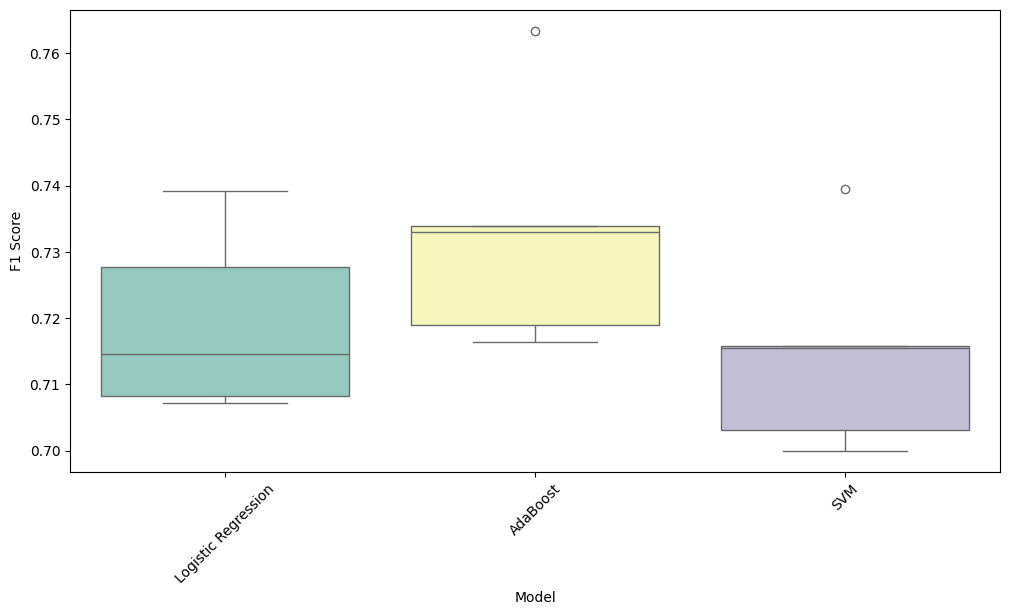

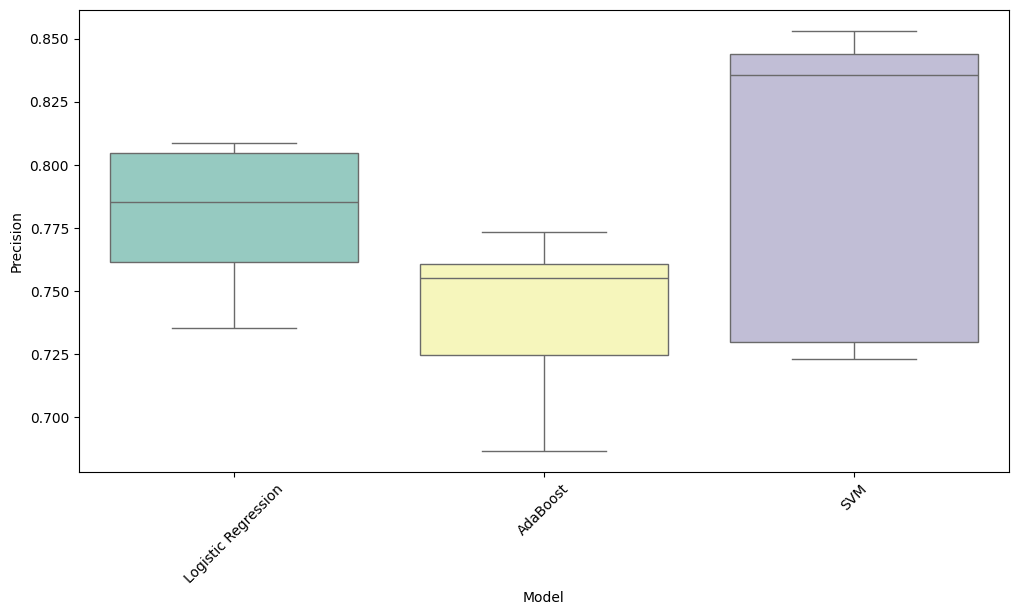

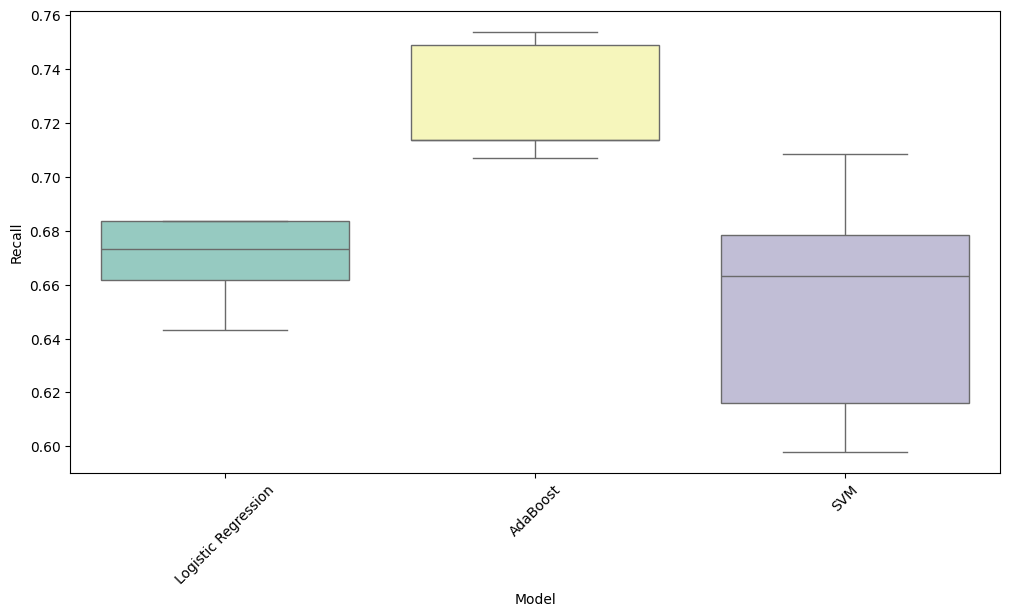

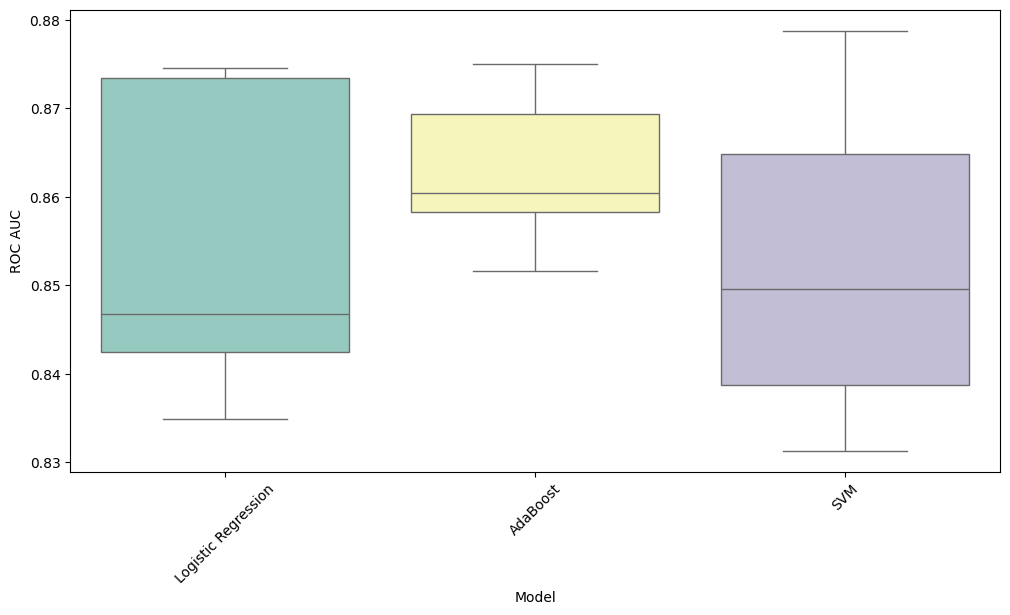

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot de F1
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='F1 Score', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da precisão
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Precision', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot do recall
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Recall', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da ROC AUC
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='ROC AUC', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()


### Seleção de modelo

Mostra os resultados do Outer Fold, sumarizando as avaliações no fold de teste e melhores parâmetros estudados.

In [285]:
display(results_df)

,Model,Outer Fold Number,Params,F1 Score,Precision,Recall,ROC AUC
0,Logistic Regression,0,{'Modelo__C': 15.278419855369538},0.714667,0.761364,0.673367,0.874563
1,Logistic Regression,1,{'Modelo__C': 0.11253950711110934},0.727778,0.808642,0.661616,0.846763
2,Logistic Regression,2,{'Modelo__C': 16.819012456403065},0.707182,0.785276,0.643216,0.842432
3,Logistic Regression,3,{'Modelo__C': 858.347346755648},0.739130,0.804734,0.683417,0.873385
4,Logistic Regression,4,{'Modelo__C': 1.1905614000333273},0.708333,0.735135,0.683417,0.834853
5,AdaBoost,0,"{'Modelo__n_estimators': 422, 'Modelo__learnin...",0.763359,0.773196,0.753769,0.875058
6,AdaBoost,1,"{'Modelo__n_estimators': 449, 'Modelo__learnin...",0.732984,0.760870,0.707071,0.858250
7,AdaBoost,2,"{'Modelo__n_estimators': 65, 'Modelo__learning...",0.718987,0.724490,0.713568,0.860421
8,AdaBoost,3,"{'Modelo__n_estimators': 306, 'Modelo__learnin...",0.733850,0.755319,0.713568,0.869353
9,AdaBoost,4,"{'Modelo__n_estimators': 487, 'Modelo__learnin...",0.716346,0.686636,0.748744,0.851579


Selecionaremos para o treinamento final a pipeline de modelagem (algoritmo + hiperparâmetros) com melhor F1-Score, nossa métrica principal.

In [286]:
pipeline_max_f1 = results_df.loc[results_df['F1 Score'].idxmax()]
print(f"A pipeline {pipeline_max_f1['Model']} obteve a melhor F1-score e tem como hiperparâmetros otimizados: \n\t{pipeline_max_f1['Params']}")

A pipeline AdaBoost obteve a melhor F1-score e tem como hiperparâmetros otimizados: 
	{'Modelo__n_estimators': 422, 'Modelo__learning_rate': 0.018522541249615106}


# 2. Avaliação de desempenho final

Utilizem as métricas definidas na primeira parte do trabalho para comparar os modelos, garantindo que a métrica seja a correta para o problema, considerando eventuais desbalanceamentos nos dados.
Após a otimização de hiperparâmetros de todos os modelos candidatos (isto é, aqueles treinados com 2-3 estratégias mais promissoras escolhidas com base em T1), o desempenho dos modelos nos dados de teste deve ser comparado para identificar qual modelo oferece o melhor desempenho global e quais são os pontos fortes e fracos de cada modelo. Com base nesta análise, os grupos devem tentar definir o modelo mais indicado para atacar o problema abordado.

Criem gráficos e visualizações que ajudem a ilustrar as comparações entre os modelos. Conforme apropriado, obtenham curvas ROC ou PR, gráficos de barras comparando as métricas de cada modelo, e/ou matrizes de confusão.

Identifiquem o melhor modelo, ou se não há um modelo claramente melhor, quais são os “vencedores” e as situações e características de vantagem e desvantagem entre eles. Verifiquem os casos (instâncias/amostras) onde o melhor modelo (ou os melhores, em caso de “empate”) vai(vão) bem ou mal. A análise não deve ser pra cada amostra individual, mas de maneira agregada. Por exemplo, se o problema for de classificação, analise qual é a classe mais difícil para o modelo, e se há amostras “confusas” no sentido que seus atributos parecem realmente pertencer a outra classe. Se o problema é de regressão, veja se há algum padrão onde os erros são maiores.

---

Após otimizar e encontrar a melhor pipeline de modelagem, realizaremos seu treinamento em todo o conjunto treino, para finalmente validar no conjunto de teste, reservado anteriormente para este momento.

In [290]:
best_params = pipeline_max_f1['Params']

print(best_params)

# Evaluate the best model on the test set
best_pipeline = make_pipeline(model=algo_dict['AdaBoost'])
best_pipeline.set_params(Modelo__n_estimators = best_params['Modelo__n_estimators'],
                         Modelo__learning_rate = best_params['Modelo__learning_rate'])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

{'Modelo__n_estimators': 422, 'Modelo__learning_rate': 0.018522541249615106}


/home/leonardoazzi/cic/24-2/ml/trabalho/student-dropout-prediction/src/env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



In [291]:
final_results = {
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}

print("Avaliação final no conjunto de testes", final_results)

Avaliação final no conjunto de testes {'F1 Score': np.float64(0.7620164126611958), 'Precision': np.float64(0.7629107981220657), 'Recall': np.float64(0.7611241217798594), 'ROC AUC': np.float64(0.8897698887782766)}


/tmp/ipykernel_21648/511959001.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




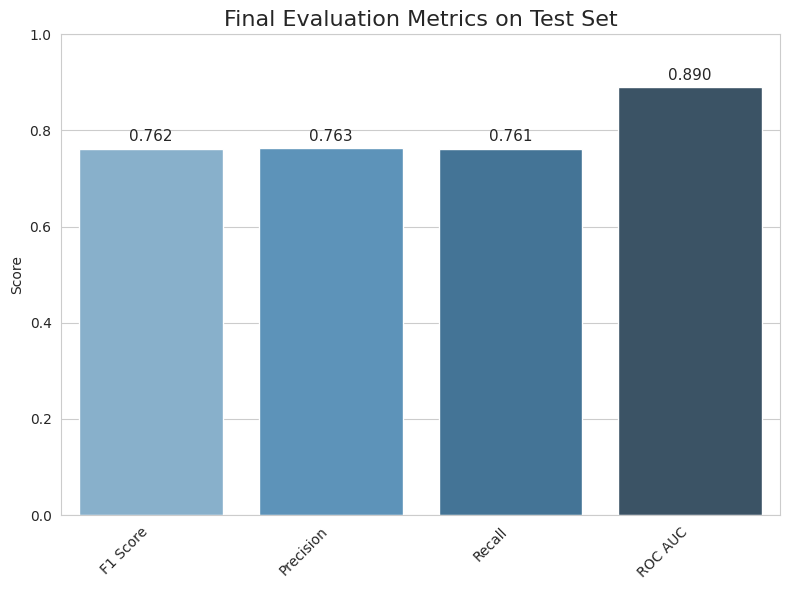

In [292]:
# Convert final_results into a DataFrame for easy plotting
final_results_df = pd.DataFrame(list(final_results.items()), columns=['Metric', 'Value'])

# Set a style for seaborn
sns.set_style("whitegrid")

# Create a figure and axes
plt.figure(figsize=(8, 6))

# Plot the bar chart
sns.barplot(x='Metric', y='Value', data=final_results_df, palette='Blues_d')

# Add labels and title
plt.title("Final Evaluation Metrics on Test Set", fontsize=16)
plt.ylim(0, 1.0)
for index, row in final_results_df.iterrows():
    plt.text(index, row['Value'] + 0.01, f"{row['Value']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

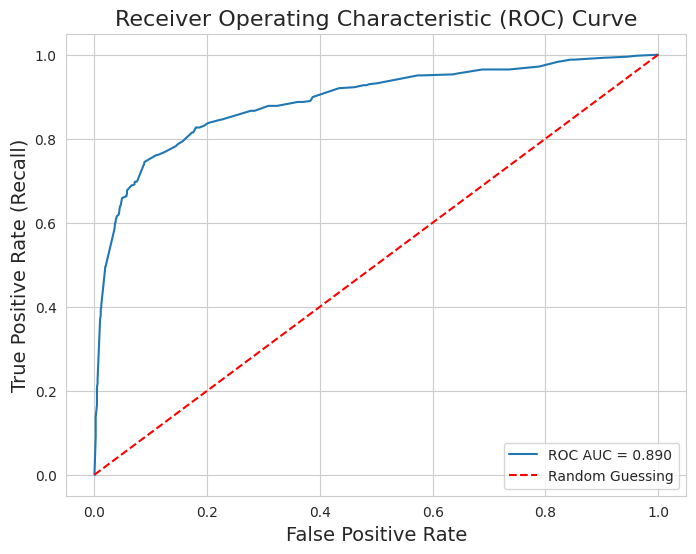

In [293]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {final_results['ROC AUC']:.3f}")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing")

plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate (Recall)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

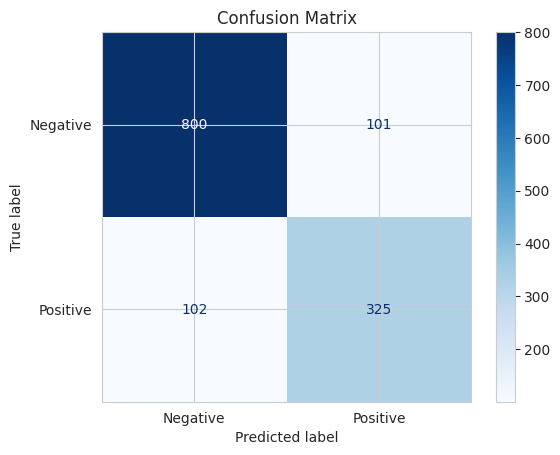

In [294]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = best_pipeline.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using the built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Exporta hiperparâmetros

In [295]:
pipeline_max_f1.to_csv('../data/otimizacao-hiperparams.csv', index=False)  

OSError: Cannot save file into a non-existent directory: '../data'